In [13]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [14]:
#Using the GPU for all processes hereon
if torch.cuda.is_available():
    device = torch.device('cuda')
#Support for M1 Mac
elif torch.has_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='mps')

In [15]:
#Downloading the data from kaggle
#from google.colab import files

#upload kaggle.json here
#files.upload()
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle competitions download -c deep-learning-for-msc-coursework-2022
#! unzip /content/deep-learning-for-msc-coursework-2022.zip

### Loading the Data using the ImageFolder class

In [ ]:
from torchvision.transforms.transforms import Resize
#Since the data is unbalanced, we can apply some transforms to augment
#the minority class as well as generalise the dataset to avoid 
#overfitting/underfitting

#Creating a transform for the train set
train_transform = transforms.Compose([transforms.Resize(28),
                                      transforms.RandomRotation(15),
                                      transforms.RandomResizedCrop(32),
                                      transforms.RandomHorizontalFlip(0.2),
                                      transforms.RandomVerticalFlip(0.2),
                                      transforms.ToTensor()])

#Creating a transform for the test set. Since the test set is roughly
#balanced, no augmentation will be applied to it.
test_transform = transforms.Compose([transforms.Resize(28),
                                     transforms.ToTensor()])

#Creating the train and validation data split
dataset = datasets.ImageFolder("/content/train/train", train_transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [1500, 200])

#Creating the Test dataset
test_dataset = datasets.ImageFolder("/content/test", test_transform)

In [ ]:
#Loading the datasets using a dataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset)

### Viewing some images and classes from the data



In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

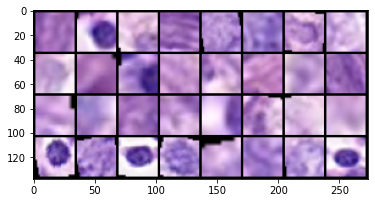

Cancer Immune Connective Cancer Cancer Cancer Connective Normal Connective Cancer Immune Connective Connective Cancer Connective Cancer Normal Connective Cancer Cancer Immune Cancer Connective Connective Immune Cancer Immune Normal Normal Normal Normal Immune


In [ ]:
classes = dataset.classes
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

### Training a simple ConvNet baseline model





In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3) #Conv Layer 1
        self.pool = nn.MaxPool2d(2, 2) #MaxPooling Layer
        self.conv2 = nn.Conv2d(32, 16, 3) #Conv Layer 2
        self.dropout = nn.Dropout2d(0.2) #Adding a dropout to prevent overfitting
        self.fc1 = nn.Linear(576, 1024) #Fully Connected Layer 1
        self.fc2 = nn.Linear(1024, 60) #Fully Connected Layer 2
        self.fc3 = nn.Linear(60,4) #final layer has out_features since there are 4 classes

    #Defining a forward pass of the network
    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x))) #Adding ReLU Activation to the first conv layer
      x = self.pool(F.relu(self.conv2(x))) #Adding ReLU Activation to the second layer
      x = torch.flatten(x, 1) # flatten the dimensions
      x = F.relu(self.fc1(x)) #Adding ReLU activation to the fully connected layer 1
      x = F.relu(self.fc2(x)) #Adding ReLU activation to the fully connected layer 2
      x = self.fc3(x)
      return x

In [ ]:
#the model class is created
#Instantiate the model
base_model = ConvNet().to(device)
base_model 

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=576, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=4, bias=True)
)

### Creating the Optimiser and Loss Function

In [ ]:
#We will use Adam optimiser and crossentropy loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)

### First Batch of training images

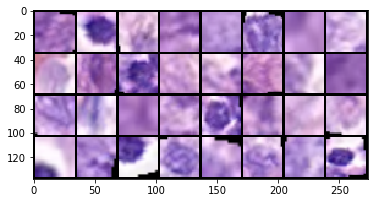

In [ ]:
# show the first batch of training data (you don't need to understand this code)
train_images, train_labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(train_images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

### Defining the Training Loop


In [ ]:
#Keeping track of the train and validation losses
#to ensure the model is not overfitting
training_loss = []
validation_loss = []

#Training for 20 epochs. This will loop over the dataset 20 times
num_epochs = 20

for epoch in range(num_epochs):
  #Initial loss is 0
  train_loss = 0
  valid_loss = 0
  #training the model
  base_model.train()
  for img, target in train_loader:
    #Moving the data to GPU
    img = img.to(device)
    target = target.to(device)
    #Clearing the gradients
    optimizer.zero_grad()
    #First predictions
    output = base_model(img)
    #Calculating the loss
    loss = criterion(output, target) #Comparing the predictions vs actual labels
    #Backward pass of the network
    loss.backward()
    optimizer.step() #parameter update
    #Updating the train loss values
    train_loss += loss.item() * img.size(0)

  #Evaluating the model
  base_model.eval()

  #Calculating the validation loss
  for val_img, val_target in val_loader:
    val_img = val_img.to(device)
    val_target = val_target.to(device)

    val_output = base_model(val_img)

    val_loss = criterion(val_output, val_target)
    #Updating the validation loss
    valid_loss += val_loss.item() * val_img.size(0)
  
  #calculating the average loss across all epochs
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(val_loader.sampler)
  training_loss.append(train_loss)
  validation_loss.append(valid_loss)

  #Show the training progress
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,
                                                                     train_loss, 
                                                                     valid_loss))


Epoch: 0 	Training Loss: 1.239171 	Validation Loss: 0.967380
Epoch: 1 	Training Loss: 0.940883 	Validation Loss: 0.908594
Epoch: 2 	Training Loss: 0.756549 	Validation Loss: 0.500634
Epoch: 3 	Training Loss: 0.615334 	Validation Loss: 0.530308
Epoch: 4 	Training Loss: 0.641023 	Validation Loss: 0.536045
Epoch: 5 	Training Loss: 0.631002 	Validation Loss: 0.532260
Epoch: 6 	Training Loss: 0.585853 	Validation Loss: 0.489984
Epoch: 7 	Training Loss: 0.582469 	Validation Loss: 0.503575
Epoch: 8 	Training Loss: 0.549398 	Validation Loss: 0.544701
Epoch: 9 	Training Loss: 0.566869 	Validation Loss: 0.459465
Epoch: 10 	Training Loss: 0.556294 	Validation Loss: 0.455629
Epoch: 11 	Training Loss: 0.504241 	Validation Loss: 0.433324
Epoch: 12 	Training Loss: 0.498365 	Validation Loss: 0.444249
Epoch: 13 	Training Loss: 0.490003 	Validation Loss: 0.455185
Epoch: 14 	Training Loss: 0.473372 	Validation Loss: 0.402840
Epoch: 15 	Training Loss: 0.529385 	Validation Loss: 0.535778
Epoch: 16 	Trainin

### Plotting the Train/Validation Loss curve

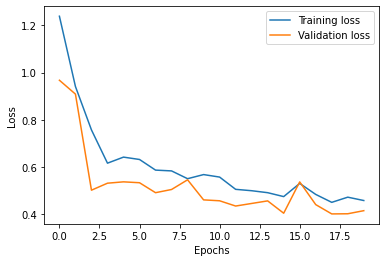

In [ ]:
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

We can see that the train and validation loss follow a similar pattern over the epochs. Both the train and validation loss are reducing overtime.

### Model Accuracy on the test set

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for val_images, val_labels in val_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        # Predicting on the test images
        val_outputs = base_model(val_images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(val_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == val_labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 77.23214285714286 %


The accuracy of the network on the validation set is ~ 76.33%

In [ ]:
#Defining the AutoEncoder model by combining the 
#encoder and decoder modules

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    #Creating the Encoder network
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
        nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 3, 2, stride=2, padding=1),  # b, 1, 28, 28
        nn.Tanh()
        )
  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [ ]:
#Instantiating the model
autoencoder = AutoEncoder().to(device)
autoencoder

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [ ]:
#defining the loss and optimizers
ae_criterion = nn.BCELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
#Training the autoencoder on the test set
ae_num_epochs = 50
for ae_epoch in range(ae_num_epochs):
  ae_total_loss = 0
  for ae_data in test_loader:
    ae_img, _ = ae_data
    ae_img = ae_img.to(device)
    # ===================forward=====================
    ae_output = autoencoder(ae_img)
    ae_loss = ae_criterion(ae_output, ae_img)
    # ===================backward====================
    ae_optimizer.zero_grad()
    ae_loss.backward()
    ae_optimizer.step()
    ae_total_loss += ae_loss.data
    # ===================log========================
  print('epoch [{}/{}], loss:{:.6f}'
          .format(ae_epoch, ae_num_epochs, ae_total_loss))

RuntimeError: ignored

### Generating the Submission File for the model predictions


In [ ]:
test_predictions = []
test_predictions_id = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, (test_images, test_labels) in enumerate(test_loader,0):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        # Predicting on the test images
        test_outputs = base_model(test_images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(test_outputs.data, 1)
        test_predictions.append(predicted)
        imgid, _ = test_loader.dataset.samples[i]
        test_predictions_id.append(imgid.split('/')[-1])


In [ ]:
def convert_to_labels(predicted):
  return dataset.classes[predicted]

img_label = []
for i in test_predictions:
  tensor_to_labels = convert_to_labels(i)
  img_label.append(tensor_to_labels)

#create new df
df = pd.DataFrame({'id':test_predictions_id,'type':img_label})
df.to_csv("submission.csv",index=False)